*You may navigate the notebook through the table of contents on the left.*

---
# **Dimensionality reduction for neural data**
---

Leonardo Agueci <sup>1</sup>, Arthur Pellegrino<sup>2</sup> and N. Alex Cayco Gajic<sup>1</sup>

<sup>1</sup>Ecole Normale Superieure, <sup>2</sup>University of Edinburgh

# Introduction

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1bWAEsI-pGOSUWmMW3TfSmTVk1B32jSkR" width="550px;">
</p>

In this tutorial you will extensively learn about principal component analysis (PCA) [1,2] and its application on neural data. 
- In __Part I__, we introduce you to the theory underlying this dimensionality reduction method, and its relationship with singular value decomposition (SVD). Then, we will extend its usage to tensors, basic step for applying this method to standard neural data; as a ___bonus___, you will find a brief introduction to tensor component analysis (TCA) and to sliceTCA. Finally, you will find a description of the bi-cross validation method. 
- In __Part II__ you will use this theoretical background to implement PCA.
- __Part III__ focuses on how to cross-validate the number of components.
- In __Part IV__ you will apply PCA to neural data recorded during hand movement.
- Finally, __Part V__ we will finally try to gain some understanding of what could be encoded in our neural recordings using some simple linear decoders

___Remarks:___

- Code cells are partially filled sometimes, for helping you with coding and visualization. Although you can change any part of the code as you prefer (e.g. for improving visualization), we recommend to add you code only in the parts delimited as follows (for plots, you might find some settings that might be helpful):

```(python)
# Fill in your code below
###########################

# Instruction 1 
# your code here

# Instruction 2
plt.plot(# your code here , some_useful_settings)

###########################
```

- __If you want to run this notebook offline, make sure your python environment has installed the following libraries:__
    - matplotlib
    - numpy
    - pickle
    - mpl_toolkits
    - sklearn
    - tqdm
    - scipy


# **Part I.** The theory behind (multi)linear dimensionality reduction



One of the reasons for the enduring popularity of PCA is its analytical interpretability. To demonstrate this, we will present two mathematically equivalent formulations of PCA: 1) identifying the directions of maximum projected variance, and 2) finding the best low-dimensional approximation to the data matrix. By setting up these two questions as constrained optimization problems (following [2]), it can be shown that the two formulations yield the same solution: the eigenvalues and eigenvectors of the data covariance matrix. We will then cover the relationship between PCA and singular value decomposition (SVD), and the Eckart-Young Theorem which guarantees that the SVD is the closest low-rank approximation to the data matrix. The equivalence of these two formulations (the closest low rank approximation and vs directions of maximum variance) will set up the intuition necessary to understand data tensor extensions such as TCA or sliceTCA.

## The equivalent formulations of PCA

### PCA as the directions of maximum projected variance

When discussing PCA, we follow convention that we are working with a data matrix $\mathbf{X} \in \mathbb{R}^{N \times K}$ where $N$ is the number of neurons and $K$ the number of samples. We further assume that the data has already been centered, that is the activity of each neuron has been subtracted its mean. The sample covariance matrix $\mathbf{\hat\Sigma}\in \mathbb{R}^{N \times N}$ is then defined as $\mathbf{\hat \Sigma} = \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T$.

We start by seeking the vector $\mathbf{u} \in \mathbb{R}^N$ that maximizes the variance of the projected data. We further add the constraint that $\bf u$ must be normalized ($\mathbf{u}^T\mathbf{u}=1$, else the problem is unbounded). Then, the projected data is simply $\mathbf{u}^T\mathbf{X}\in \mathbb{R}^{K}$. The projected variance is then given by:

\begin{align}
\text{var}(\mathbf{u}^T\mathbf{X}) =& \frac{1}{N_\text{samples}}(\mathbf{u}^T \mathbf{X})(\mathbf{X}^T \mathbf{u}) \\
=&\mathbf{u}^T \left ( \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T \right ) \mathbf{u} \\
=& \mathbf{u}^T \mathbf{\hat \Sigma} \mathbf{u}.
\end{align}

One way to solve such an optimization problem is to use [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). First, we define the Lagrange function:

$$ L(\mathbf{u},\lambda) = \mathbf{u}^T \mathbf{\hat \Sigma u} + \lambda(1-\mathbf{u}^T\mathbf{u})$$

A necessary condition for $\mathbf{u}$ to be a maximum under the imposed constraint is that it must be a zero of the gradient of the Lagrange function:

$$ \nabla_{\mathbf u} L = \mathbf{\hat \Sigma u} - \lambda \mathbf{u} = 0 $$

That is, $ \mathbf{\hat \Sigma u} = \lambda \mathbf{u}$, therefore  $\mathbf{u}$ must be an eigenvector of the data covariance matrix and $\lambda$ its corresponding eigenvalue. Combining this with the projected variance as derived above, we get $\text{var}(\mathbf{u}^T\mathbf{X}) = \mathbf{u}^T \mathbf{\hat \Sigma} \mathbf{u} = \lambda\mathbf{u}^T  \mathbf{u} = \lambda$. Therefore the vector that maximizes the projected variance is the eigenvector of $\bf \hat \Sigma$ with the largest eigenvalue.

We can show inductively that by repeating this argument (with an additional constraint that each vector is orthogonal to the previously identified vectors), that the directions of maximum projected variance are given by the eigenvectors of $\bf \hat \Sigma$ and the projected variances by their corresponding eigenvalues.

The first $R$ principal components are given by projecting the data $\bf X$ onto the $R$ eigenvectors of the covariance matrix with largest eigenvalues. The eigenvectors are often called the loadings or weights, and the projected data are often called the scores.

Finally, we note that since $\bf \hat \Sigma$ is symmetric, its eigenvectors form an orthonormal basis for $\mathbb{R}^N$. In the context of PCA, this means that the loading vectors are orthogonal and the scores are uncorrelated.

### PCA as the low-dimensional projection that minimizes reconstruction error

In this second formulation we will attempt to find the low-dimensional projection of $\mathbf{X}$ with the smallest *reconstruction error*. We'll denote each sample (i.e. column) of the data matrix as ${\bf x}_n\in\mathbb{R}^N$. We thus seek an $R$-dimensional subspace such that, on average over all samples, the data projected on this subspace $\mathbf{\hat x}_n\in\mathbb{R}^N$ is closest to ${\bf x}_n$. We'll call our candidate orthonormal basis $\mathbf{u}_1,\dots,\mathbf{u}_R\in\mathbb{R}^N$, which spans this $R$-dimensional subspace within the $N$-dimensional activity space. Then, the estimate of each sample can be written as the linear combination:

$${\bf \hat x}_n =\sum_{i=1}^R \beta_{ni} \mathbf{u}_i$$

for some coefficients $\beta_{ni}$, which we would like to find as a function of $\mathbf{u}_i$ and $\mathbf{x}_n$.

Note that we're still missing $N-R$ vectors needed to form a complete orthonormal basis for the full activity space: we'll simply call such vectors $\mathbf{u}_{R+1},\dots,\mathbf{u}_N$. This means that we can rewrite each sample as:

$${\bf x}_n =\sum_{i=1}^N \alpha_{ni} \mathbf{u}_i$$

Since the $\mathbf{u}_i$'s are orthonormal, the coefficients are simply given by the projections of the data onto each basis vector: $\alpha_{ni} =\mathbf{x}_n^T \mathbf{u}_{i} $. You can verify this by taking the dot product of the above equation with $\mathbf{u}_j$ (remembering that $\mathbf{u}_i$'s being orthonormal is defined as: $\mathbf{u}_i\cdot \mathbf{u}_j=1$ if $i=j$ else $0$).

We can write the mean-squared error as:
$$ E =  \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 $$
First, using our expressions for the samples above, we can write the residual on the right as:

\begin{align}
 \mathbf{x}_n - \mathbf{\hat x}_n = \sum_{i=1}^R (\alpha_{ni}-\beta_{ni})\mathbf{u}_i + \sum_{j=R+1}^N \alpha_{nj}\mathbf{u}_j
\end{align}

Now, noting that $\lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 = ( \mathbf{x}_n - \mathbf{\hat x}_n )\cdot  (\mathbf{x}_n - \mathbf{\hat x}_n)$, and using the fact that the $\mathbf{u}_i$'s are orthonormal, the norm of the residual can be simplified as:

\begin{align}
\lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 = \sum_{i=1}^R (\alpha_{ni}-\beta_{ni})^2 + \sum_{j=R+1}^N \alpha_{nj}^2
\end{align}

Finally, we can minimize the error by differentiating it as:
$$\frac{d E}{d \beta_{ni}} =  \frac{2}{N \cdot N_\text{samples}} (\beta_{ni} - \alpha_{ni})$$

which means that the $\beta_{ni}$ that minimizes the MSE is given simply by $\beta_{ni} = \alpha_{ni} = \mathbf{x}_n^T \mathbf{u}_i$. In retrospect this makes sense since the error should be minimized by projecting the data onto the low-dimensional subspace. We can now expand the error as:

\begin{align}
E =& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N \alpha_{nj}^2 \\
=& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N (\mathbf{x}_n^T \mathbf{u}_j)^2 \\
=& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N (\mathbf{u}_j^T\mathbf{x}_n )(\mathbf{x}_n^T \mathbf{u}_j) \\
=& \frac{1}{N} \sum_{j=R+1}^N \mathbf{u}_j^T \mathbf{\hat \Sigma u}_j
\end{align}
Where last step follows from $\mathbf{x}_n$ being mean-centered. It now remains to find an orthonormal basis $\mathbf{u}_j$ that minimizes the mean squared error. In the case that $R=N-1$, we have the same Lagrangian as before (up to a scaling factor):
$$ L(\mathbf{u},\lambda) = \frac{1}{N} \mathbf{u}^T \mathbf{\hat \Sigma u} + \lambda(1-\mathbf{u}^T\mathbf{u})$$
Again the solutions are the eigenvectors of the covariance matrix. This time, since we want to *minimize* the reconstruction error, we choose the eigenvector with smallest eigenvalue for the residual, which means that the low-dimensional subspace we project the data on is spanned by the remaining eigenvectors with larger eigenvalues.

*In general,* it can be shown that taking the $R$ largest eivenvectors of the covariance matrix as the principal subspace solves the constrained minimization of the MSE, resulting in the same solution as in the previous section. *Therefore,* PCA can be formulated in two mathematically equivalent forms: maximizing the directions of projected variance, or minimizing the reconstruction error of a low-dimensional projection.


### PCA as a low-rank approximation to the data matrix

So far we saw PCA as solving two different constrained optimization problems by projecting of the data onto the eigenvectors of the covariance matrix. Further, since the covariance matrix has an orthonormal set of eigenvectors, this projection can be considered as a change of basis from Cartesian coordinates (i.e., each dimension represents a different neuron) to a more "natural" basis of the data (i.e., each dimension represents a different covariability pattern across the population). Mathematically this projection is given by the equation:
$$ \mathbf{Z} = \mathbf{U}^T \mathbf{X}$$
where $\bf U \in \mathbb{R}^{N\times N}$ is a matrix whose columns are given by the orthonormal eigenvectors of $\mathbf{\hat \Sigma}$, in order of descending eigenvalue magnitude (which is the variance of the projected data, therefore this ranks the components by how much variance of the data they capture).

Note that since its columns $\mathbf{u}_i$ are orthonormal, $\bf U$ is a unitary matrix. An important property of unitary matrices is that $\mathbf{U}^{-1} = \mathbf{U}^T$. To see this, note that the $\mathbf{U}^T \mathbf{U} = \mathbf{I}$ falls out naturally from matrix multiplication, as $(\mathbf{U}^T \mathbf{U})_{ij}=\mathbf{u}_i^T\mathbf{u}_j = \delta_{ij}$ by orthonormality. To prove that $ \mathbf{U} \mathbf{U}^T = \mathbf{I}$, we can multiply both sides of the equation above by $\mathbf{U}$ on the left and $\mathbf{U}^{-1}$ on the right as follows:
\begin{align}
\mathbf{U}^T \mathbf{U} &= \mathbf{I} \\
\mathbf{U}(\mathbf{U}^T \mathbf{U})\mathbf{U}^{-1} &= \mathbf{U}\mathbf{U}^{-1}\\
\mathbf{U}\mathbf{U}^T &= \mathbf{I} \\
\end{align}

This is important in the context of PCA because it means we can easily move $\mathbf{U}$ to the other side of the equation to project the scores back into the original basis, returning the original data matrix:
$$\mathbf{U} \mathbf{Z} = \mathbf{X}$$
and now we see that PCA is a *matrix decomposition*, meaning that it decomposes the data matrix into a product of two matrices: the new basis vectors (or loadings) $\bf U$ and the projected data (or scores) $\mathbf Z$.

In dimensionality reduction, the purpose is to reduce the number of features used to capture the data. In PCA, this is done by taking the first $R$ components, which correspond to the largest eigenvalues (and thus the directions of largest projected variance). To do this we simply truncate the projection matrix after the first $R$ columns to get $\mathbf{ U }_{R}\in \mathbb{R}^{N\times R}$. Then the $R$-dimensional scores are still given by the same formula:
$$ \mathbf{Z}_R = \mathbf{U}_{R}^T \mathbf{X}$$

However we cannot simply move $\mathbf{U}_{R}$ to the other side of the equation. While we still have $\mathbf{U}_{R}^T  \mathbf{U}_{R} = \mathbf{I}$ (due to orthonormality of the columns), we can no longer guarantee that $ \mathbf{U}_{R} \mathbf{U}_{R}^T  = \mathbf{I}$ since our proof above relied on the existence of $\mathbf{U}_{R}^{-1}$, which does not exist for non-square matrices ($R< N$)! Geometrically, this makes sense since we can project from a high-dimensional space to a low-dimensional space but cannot invert the projection to recover the exact original data.

We can try to revert the transformation anyway by projecting the top $R$ components back into the $N$-dimensional space using $\mathbf{U}_R$. This results in the following *approximation* to the data matrix:
$$ \mathbf{ \hat X} = \mathbf{U}_{R} \mathbf{Z}_R$$
Another way to write this approxmination is to expand it as a sum of the outer products of the column.
$$ \mathbf{ \hat X} = \sum_{r=1}^R \mathbf{u}_{r} \mathbf{ z}^T_r$$
where $ \mathbf{u}_{r}$ are the columns of $ \mathbf{U}$ and $ \mathbf{ z}^T_r$ are the rows of $\mathbf{Z}$. Each column of $\mathbf{\hat X}$ is a linear combination of the $R$ basis vectors, so the rank of $ \mathbf{ \hat X} $ is (at most) $R$. Equivalently, the approximated data will lie on an $R$-dimensional subspace of $\mathbb{R}^N$ spanned by the new basis $\mathbf{u}_1,\dots,\mathbf{u}_R$.

This brings us back to the low-dimensional projection view that we saw previously, which further suggests that it may be the best low-rank approximation of the data matrix. This is indeed the case, as we will see in the next section.


### Relationship between PCA and SVD

PCA is very closely related to a more general matrix decomposition called the singular value decomposition (SVD). It is an amazing fact that any rank-$R$ matrix can be decomposed into three matrices:
$$ {\mathbf X} = {\mathbf U S} \mathbf{V}^T$$
where ${\mathbf U} \in \mathbb{R}^{N \times R}$ and $\mathbf{V} \in \mathbb{R}^{K \times R}$ have orthonormal columns (called the left and right singular vectors, respectively) that define new rotated bases for their respective vector spaces, and $\mathbf{S}\in \mathbb{R}^{R \times R}$ is a positive diagonal matrix (whose diagonal elements $\sigma_i$ are called the singular values, and are ranked in decreasing order). Most often, you will equivalently find it defined with, $U\in\mathbb{R}^{N\times \min\{N,K\}}$, $S\in\mathbb{R}^{\min \{N,K\}\times \min\{N,K\}}$, $V\in\mathbb{R}^{\min\{N,K\}\times N}$, in which case the rank of $\bf X$ is simply the number of non-zero singular values. The SVD can be thought of as decomposing a matrix into how it operates on vectors: by taking a $K$-dimensional vector, rotating it into a new basis, shrinking or stretching the new coordinates according to $\sigma_i$, and projecting it into $\mathbb{R}^N$.

How does this relate to PCA? To see this, let's again assume that $\mathbf{X}$ is mean-centered and calculate the covariance matrix using the SVD:
\begin{align}
\mathbf{\hat \Sigma} =& \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T \\
=& \frac{1}{N_\text{samples}}\mathbf{USV}^T\mathbf{VSU}^T \\
=& \frac{1}{N_\text{samples}}\mathbf{US}^2\mathbf{U}^T \\
\end{align}
which is an eigenvalue decomposition of the covariance matrix (up to the scaling). Therefore the transformed basis vectors ${\mathbf U}$ in SVD and PCA are identical, and the eigenvalues and singular values are related as $\lambda_i = \sigma_i^2/N_\text{samples}$. Consistent with the previous definitions, the scores in PCA are given by $\mathbf{Z=U}^T\mathbf{X=U}^T\mathbf{USV}^T=\mathbf{SV}^T$. Therefore, in the language of SVD, dimensionality reduction with PCA is equivalent to truncating the decomposition after $R$ singular values. This means taking only the first $R$ columns of ${\mathbf U}$ and ${\mathbf V}$ as well as the upper $R\times R$ corner of $\mathbf S$ to get the following rank-$R$ approximation:
$$ \mathbf{\hat X} = \mathbf {U}_R \mathbf{S}_{R} \mathbf{V}_R^T$$

Further, the [Eckart-Young Theorem](https://rich-d-wilkinson.github.io/MATH3030/3-5-lowrank.html) states that the truncated SVD approximation above gives the rank-$R$ that is closest to the data matrix in the Frobenius norm:
$$\min_{\text{rank}(\mathbf{Y}) \leq R} \lVert  \mathbf{X - Y} \rVert_F$$
with $\lVert  \mathbf{X - \hat X} \rVert_F = \left(\sum_{i=R+1}^N \sigma_i^2\right)^\frac{1}{2}$. Equivalently, this means that taking the top $R$ principal components PCA results in the best low-rank approximation to the data with the following MSE:
$$E = \frac{1}{N \cdot N_\text{samples}}\sum_{i=R+1}^{N}\sigma_i^2 $$

Together with the maths demonstrated above, this shows that there is a deep connection between minimizing the error of a low rank (or low-dimensional) approximation and capturing covariability patterns in neural data. In the following section we will discuss this idea in extension to neural data tensors.

## From matrices to tensors
<a id='tensors'></a>
So far, we have focused on reducing the dimensionality of a matrix $\mathbf{X}\in \mathbb{R}^{N \times K}$. However, in neuroscience we often work with a data *tensor* $\mathcal{X}\in \mathbb{R}^{N \times T \times K}$, where $N$ is the number of neurons, $K$ the number of *trials* and $T$ the number of time points.

The first key element to notice, is that, unlike for matrices, we cannot naturally separate the variables at hand into *features* (neurons) and *samples* (time points). Instead there are two relevant notions of sampling (across time points and across trials) which we would like to keep separated to interpret the data [4]. In the following sections, we will look at three complementary ways to account for this, from which stem three dimensionality reduction methods : PCA on unfoldings [3], TCA [4] and sliceTCA [5].

### PCA on unfoldings

#### Neuron-unfolding

The first strategy, is to go back to the matrix case by *unfolding* the data tensor. For example, if we wish to keep neurons as features, we can unfold the tensor $\mathcal{X}\in \mathbb{R}^{N \times T \times K}$ into a matrix $\mathbf{X}\in \mathbb{R}^{N\times (TK)}$. If we now apply the low-rank approximation perspective on PCA to this matrix, the data can be approximated as:

$$
  \mathbf{X}\approx \mathbf{\hat X} = \mathbf{U}\mathbf{Z} \in \mathbb{R}^{N\times (TK)}
$$

where $\mathbf{U}\in\mathbb{R}^{N\times R}$ and $\mathbf{Z}\in \mathbb{R}^{R \times(TK)}$. As seen previously, this can be equivalently written as the sum of the following outer products:

$$
\mathbf{\hat X} = \sum_{r=1}^R \mathbf{u}_r\mathbf{z}^T_r
$$

where $\mathbf{u}_r \in \mathbb{R}^N$ are the columns of $\bf U$ and $\mathbf{z}_r\in\mathbb{R}^{TK}$ are the rows of $\bf V$.


Next, we can *fold* each $\mathbf{z}_r$ back into a matrix $\mathbf{W}_r\in\mathbb{R}^{T \times K}$. The outer product $\mathbf{u}_r\mathbf{z}^T_r$ is sometimes written in the form $\mathbf{u}_r\otimes \mathbf{z}_r$, which allows us to generalize the notation for the outer product of two vectors $(\mathbf{u}_r\otimes \mathbf{z}_r)_{ij}=\mathbf{u}_{r,i}\mathbf{z}_{r,j}$  to the outer product of a vector with a matrix $(\mathbf{u}_r\otimes \mathbf{W}_r)_{ijk}=\mathbf{u}_{r,i}\mathbf{W}_{r,jk}$. The figure below shows how a single *component* can be seen as either the outer product of a vector with a matrix or with a (long) vector.

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1oxa02j3jDSrY2izD9M_bpoHtWa6Ja6I1" width="500px;">
</p>

This way, we can rewrite our (SVD/PCA) approximation directly as a tensor:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{W}_r \in \mathbb{R}^{N \times T \times K}
$$

And, since the Frobenius norm is defined element-wise, the same objective as for the matrix case can be used to determine the decomposition:

$$
E(\mathbf{u}_1,..., \mathbf{u}_r, \mathbf{W}_1, ..., \mathbf{W}_r) = \lVert \mathcal{X} - \mathcal{\hat X} \rVert_F
$$

#### Trial-unfolding

We arbitrarily decided that the *neuron* leg would be the features (the $\mathbf{u}$'s). When working with matrices, this doesn't matter; in the end, the term $\mathbf{u}_r \mathbf{z}_r^T$ is symmetric, in the sense that it can be transposed (i.e. swap $\mathbf{u}_r$ and $\mathbf{z}_r$) to now consider the time points as features. When moving to tensors, this doesn't work anymore, as $\mathbf{z}_r$ now represents two variables (e.g. time and trial).

In the context of tensors, if we consider *time* as our features, we just have to unfold the tensor along another of its *legs*:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1dHfvXK4ay3gZHx2_Om35MiRgWrOcNIDY" width="500px;">
</p>

And similarly for trials [3]:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1AOPTNowx6LejxaGaMJGjqD58_KEBJcvE" width="500px;">
</p>

To keep track of the different vectors and matrices at hand, we can indicate the leg(s) of the tensor they describe as a supsercript. For trial-unfolding PCA, we would therefore write:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r
$$

Note that, formally, $\mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r \in \mathbb{R}^{K \times N \times T}$, but we have implicitely permuted the indices to match the data tensor in $\mathbb{R}^{N \times T \times K}$.

### (bonus) SliceTCA

We have just seen that applying PCA on unfoldings of a data tensor was equivalent to writing the approximation of the data tensor as a sum of outer product of vectors (the feature) and matrices (the folded scores vectors). We can generalize this concept by allowing different types of unfoldings within the same sum. Preserving the same notation as before,

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^{R_{neuron}} \mathbf{u}_r^{neuron} \otimes \mathbf{W}^{time, trial}_r  + \sum_{r=1}^{R_{time}} \mathbf{u}_r^{time} \otimes \mathbf{W}^{neuron, trial}_r  + \sum_{r=1}^{R_{trial}} \mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r
$$

This decomposition is called sliceTCA [5].

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1H5RkoRhITPLbAGHiLMKaK_WsQqk-WzfM" width="600px;">
</p>

Note that by setting (e.g.) $R_{time}=R_{trial} = 0$, we fall back onto (e.g.) the neuron-unfolding PCA decomposition. So that sliceTCA is a generalization (or in a set-theoretic sense, a superclass) of PCA on unfoldings.

### (bonus) TCA

Another strategy for going from PCA on unfoldings to a tensor decomposition is to constrain the slices to be of rank $1$. Consider again a PCA on (any) unfolding decomposition:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{W}_r \in \mathbb{R}^{N \times T \times K}
$$

If we now constrain the matrix to be of rank $1$, that is $\mathbf{W}_r = \mathbf{v}_r \mathbf{w}_r^T = \mathbf{v}_r \otimes \mathbf{w}_r$:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1STP28EUzPHYZNEkh0uC0PiUPmf4W1fx5" width="500px;">
</p>

And we thus obtain the decomposition:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{v}_r \otimes \mathbf{w}_r \in \mathbb{R}^{N \times T \times K}
$$

This decomposition is known within neuroscience as tensor component analysis (TCA, [4]) but in other fields (such as physics) is known by other names: CANDECOMP, PARAFAC, or simply the CP decomposition. Therefore, PCA is a generalization (or superclass) of TCA.

### Relationship between tensor decomposition methods

Overall, the relationsip between the three tensor decomposition methods presented here can be summarized by the following Venn diagram [5]:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1mNdFEP7gnDK72Q-jDyT1jkKs1sG4q698" width="300px;">
</p>


# **Part II.** Vizualizing and denoising data with PCA on a toy data


To familiarize yourselves with PCA/SVD, you will first write your own implementation of PCA (without using `sklearn`). Second, you will try to *guess* the rank of some simulated data using the bi-cross-validation method.

**WARNING:** In the maths above we used the convention that $\mathbf{X} \in \mathbb{R}^{N\times K} $ (i.e., the columns are the samples), as this is commonly used in neuroscience and in the PCA literature. However, other communities (notably in machine learning) use the rows as samples instead: $\mathbf{X} \in \mathbb{R}^{K\times N}$. Be mindful when you write your code that the packages you use may be using the latter notation (for example, in that case, the $\bf V$ in the SVD will represent the basis vectors, rather than the $\bf U$.).

First, execute the cell below to get started and generate your data matrix $M$ of 10 neurons and 101 time points.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3)

def exp_quad(x, l=0.1, s=1): 
    return np.exp(-x**2/(2*l**2))*s**2

n = 10
k = np.random.randint(1, n//2+1)
time_steps = 101
ts = np.linspace(0, 1, time_steps)
noise = 0.01
kernel = exp_quad

latent_gaussian = np.random.randn(time_steps, k)
covariance_matrix = kernel(np.subtract.outer(ts, ts))
L = np.linalg.cholesky(covariance_matrix+10**-6*np.eye(time_steps))

neuron_basis = np.random.randn(n, k)
time_basis = L @ latent_gaussian

M = time_basis @ neuron_basis.T + np.random.randn(n) + np.random.randn(time_steps, n)/3

print('Data matrix M (sample_size, neuron):', M.shape)

Data matrix M (sample_size, neuron): (101, 10)


**Step 1.** The first step of neural dimensionality reduction is *always* to look at the raw data first. Plot the single neuron activity generated by the previous code cell over time.

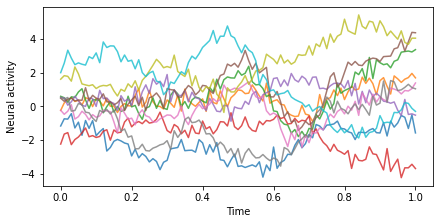

In [3]:
# Solution

fig = plt.figure(figsize=(6,3), constrained_layout=True)
ax = fig.add_subplot()

ax.plot(ts, M, alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
plt.show()

**Step 2.** Center the data matrix (subtract from each neuron its mean activity). Make a scatter plot of two arbitrarily chosen neurons, using each as one of the two dimensions. What do you notice?

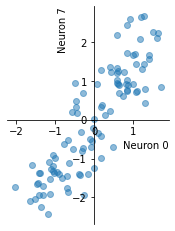

In [7]:
# Solution

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

# Center each neuron activity
M_centered = M-M.mean(axis=0)

# Plot the centered activity for neurons i and j of your choice
i, j = 0, 7
ax.scatter(M_centered[:, i], M_centered[:, j], alpha=0.5)

ax.set_aspect('equal')
ax.spines[['left', 'bottom']].set_position(("data", 0))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Neuron '+str(i), loc='right')
ax.set_ylabel('Neuron '+str(j), loc='top')
plt.show()

**Step 3.** Perform PCA using ``` np.linalg.svd ```.  Be careful with rows and columns, and verify whether the basis vectors should be $\bf U$ or $\bf V$. Make the following two plots:
* a scatter plot of projections of the data onto the first two PCs using the $S$, $V$, and $U$.
* a plot showing how the projected variance decays as a function of the number of components.

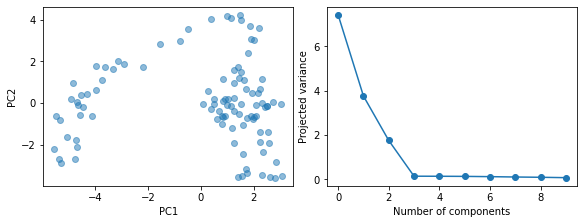

In [18]:
# Solution

# Generate U, S, V using SVD
U, S, V = np.linalg.svd(M_centered, full_matrices=False)

# Generate the projected data
projection = np.diag(S) @ U.T

# Compute the variance along each dimension (careful with matrix axes!)
projected_variance = np.var(projection,axis=1)

# Let's plot what we got
fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[0], projection[1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

**Step 4.** Now make the same plot as above using the eigenvectors of the covariance matrix.
* Calculate the sample covariance matrix.
* Use ``` np.linalg.eig ```  to get the eigenvectors and eigenvalues of the covariance matrix. Be careful with the rows and columns.
* Make a scatter plot of the data matrix on the first two eigenvectors of the covariance matrix, just as you did in Step 3. Are the two plots identical? Should they be?
* Finally plot the projected variance using the eigenvalues. Are the two plots identical?

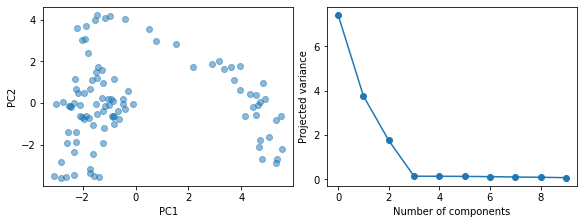

In [20]:
# Solution

# Generate the covariance matrix
Sigma = M_centered.T @ M_centered / M_centered.shape[0]

# Compute the eigenvalues using np.linalg.eig()
evals, evecs = np.linalg.eig(Sigma)

# Generate the projected data
projection = M_centered @ evecs

# Compute the variance using eigenvalues
projected_variance = np.var(projection,axis=0)


# Let's plot what we got
fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[:,0], projection[:,1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
projected_variance = np.sort(projected_variance)[::-1]
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

**Step 5.** PCA is often used as a preprocessing step for other dimensionality reduction methods due to its denoising properties. Let's try to recompose the neural firing rates using the first two principal components. Does it look denoised to you? Try to change the number of components to see the difference.<br>


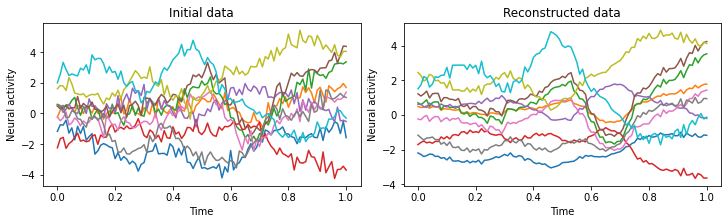

In [26]:
# Solution

n_components = 2

# let's reconstruct the data by using only few components (always remember to put back the mean)
M_reconstructed = U[:,:n_components] @ np.diag(S[:n_components]) @ V[:n_components,:] + M.mean(axis=0)

fig = plt.figure(figsize=(10,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.set_title('Initial data')
ax.plot(ts, M)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')

ax = fig.add_subplot(1,2,2)

ax.set_title('Reconstructed data')
ax.plot(ts, M_reconstructed)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
plt.show()

**Step 6.** A frequently used method to calculate the dimensionality is to plot the cumulative fraction of variance explained in the data and see when the curve levels off. Since the projected variance is given by the eigenvalues, this can be evaluated by a cumulative sum of eigenvalues normalized by the sum of all eigenvalues. Plot this as a function of the number of components. What do you think the dimensionality is?

(Text(0.5, 0, 'Number of components'), Text(0, 0.5, 'Variance explained'))

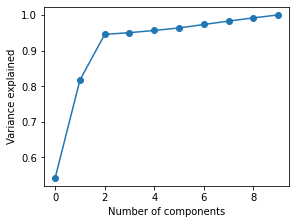

In [16]:
# Solution

# Compute the comulative (remember to normalize)
cumulative = np.cumsum(evals)/np.sum(evals)


fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative, 'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Variance explained')
plt.show()

# References

[1] Cunningham, J. P., & Yu, B. M. (2014). Dimensionality reduction for large-scale neural recordings. Nature neuroscience, 17(11), 1500-1509.

[2] Bishop, C. M. (2009). Pattern recognition and machine learning. Springer, New York.

[3] Seely, J. S., Kaufman, M. T., Ryu, S. I., Shenoy, K. V., Cunningham, J. P., & Churchland, M. M. (2016). Tensor analysis reveals distinct population structure that parallels the different computational roles of areas M1 and V1. PLoS computational biology, 12(11), e1005164.

[4] Williams, A. H., Kim, T. H., Wang, F., Vyas, S., Ryu, S. I., Shenoy, K. V., ... & Ganguli, S. (2018). Unsupervised discovery of demixed, low-dimensional neural dynamics across multiple timescales through tensor component analysis. Neuron, 98(6), 1099-1115.

[5] Pellegrino*, A., Stein*, H., & Cayco-Gajic, N. A. (2023). Disentangling mixed classes of covariability in large-scale neural data. bioRxiv.

[6] Owen, A. B., & Perry, P. O. (2009). Bi-cross-validation of the SVD and the nonnegative matrix factorization. Annals of Applied Statistics, 3(2), 564-594.

[7] Mark M. Churchland, John P. Cunningham, Matthew T. Kaufman, Stephen I. Ryu, Krishna V. Shenoy (2010).
Cortical Preparatory Activity: Representation of Movement or First Cog in a Dynamical Machine?. Neuron, Volume 68, Issue 3

[8] Churchland, M., Cunningham, J., Kaufman, M. et al. (2012). Neural population dynamics during reaching. Nature 487, 51–56.
